In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy import signal, fft
import timeit

In [49]:
# Message specification
fs = 8e6
sps = 4
Ts = 1/(fs/sps)

print(f"Symbol Time {Ts} and Symbol Freq {1/Ts}")

preamble = 0xAAAA
syncword = 0xD7     #Look at gold and hadamard codes

Symbol Time 5e-07 and Symbol Freq 2000000.0


In [50]:
def packetize(preamble, syncword, data):
    output = struct.pack("<HBB", preamble, syncword, len(data)) + bytes(data, 'utf-8')
    output = np.frombuffer(output, np.uint8)
    return output

In [51]:
packet = packetize(preamble, syncword, "Hello")
print(packet)

[170 170 215   5  72 101 108 108 111]


In [52]:
def unpack_bits(packet, sps):
    #create bit string
    bit_array = np.unpackbits(packet, bitorder='big')
    return np.repeat(bit_array, sps)
unpacked = unpack_bits(packet, sps)

In [53]:
def psk_mod(data, symbol_map):
    return symbol_map[data]

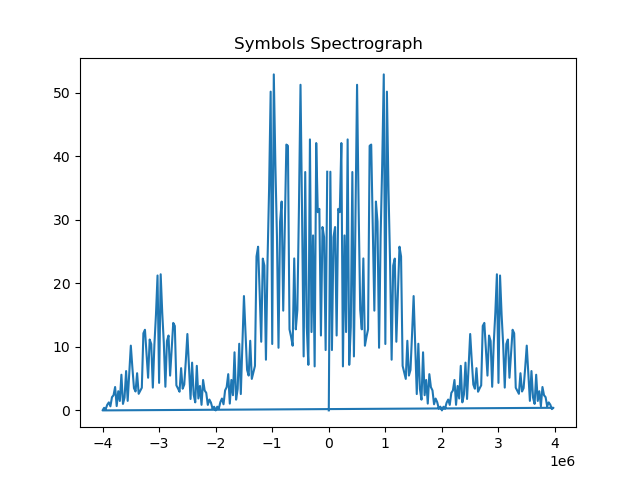

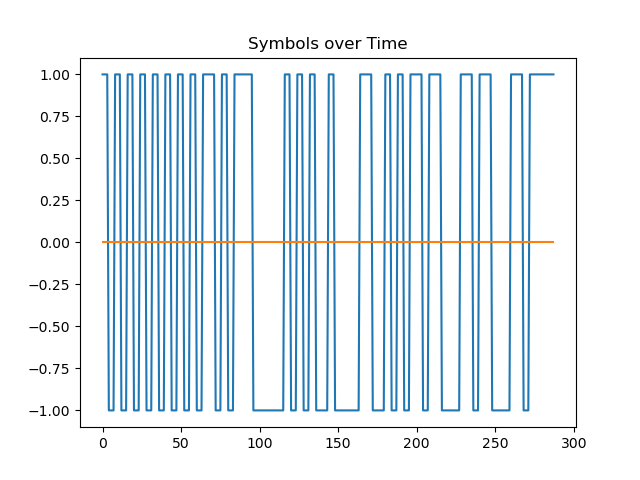

In [54]:
#bpsk_symbol_dict = {0:-1+0j, 1:1+0j}
bpsk_symbol_map = np.array([-1+0j, 1+0j])
symbols = psk_mod(unpacked, bpsk_symbol_map)

%matplotlib widget
plt.figure("Symbols over Time")
plt.title("Symbols over Time")
plt.plot(symbols.real)
plt.plot(symbols.imag)
plt.show

yf = fft.fft(symbols)
freqs = fft.fftfreq(symbols.size, d=1/fs)

plt.figure("Symbols Spectrograph")
plt.title("Symbols Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

## Root Raised Cosine Filter
You can see that from the Symbols Spectrograph that the frequency response of this signal occupies a large bandwidth with the center lobe going from -1Mhz to +1Mhz. This corelates to -1/Ts and +1/Ts. As a result we should filter frequencies greater than +/- 1/Ts. 

The raised cosine filter does this. The RRC is derived from the sinc function (boxcar filter) and consists of 1/2 cylces of cos on either side. 

The raised cos filter is designed such that it decays to 0 in the time domain with minimal number of taps. 


63
Tsymbol 4


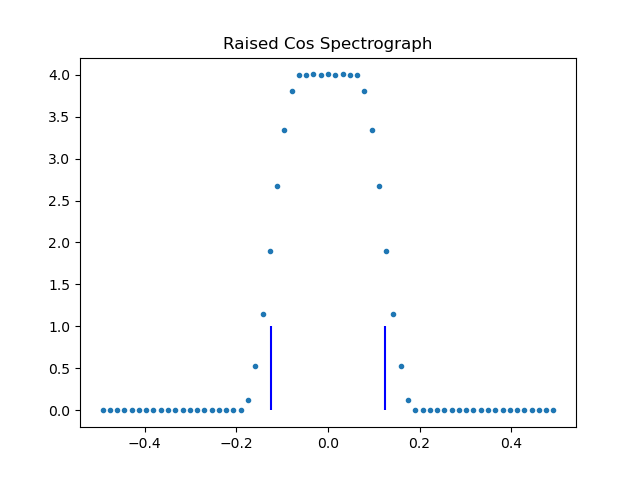

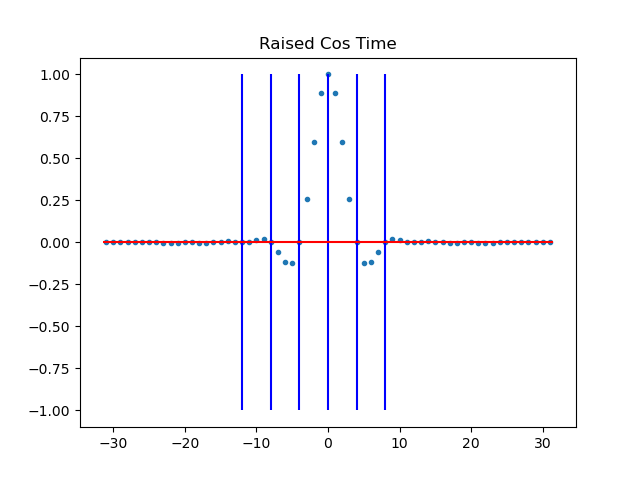

In [22]:
#Design Raised Cosine filter

ntaps = 16*sps - 1
print(ntaps)
n = np.arange(ntaps) - (ntaps-1)//2
beta = .51
Tsymbol = sps
print(f"Tsymbol {Tsymbol}")

if Tsymbol/(2*beta) in n:
    print("Filter has a tap that will result in divide by zero error")
    print(np.where(n==T/(2*beta)))
else:
    root_raised = np.cos(np.pi*beta*n/Tsymbol)*np.sinc(n/Tsymbol)/(1-(2*beta*n/Tsymbol)**2)



%matplotlib widget
plt.figure("Raised Cos over Time")
plt.title("Raised Cos Time")
plt.plot(n, root_raised, '.')
plt.vlines(np.arange(-3*sps, 3*sps, sps), -1, 1, 'b')
plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show

yf = fft.fft(root_raised)
freqs = fft.fftfreq(root_raised.size)

plt.figure("Raised Cos Spectrograph")
plt.title("Raised Cos Spectrograph")
plt.plot(freqs, np.abs(yf), '.')
plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()

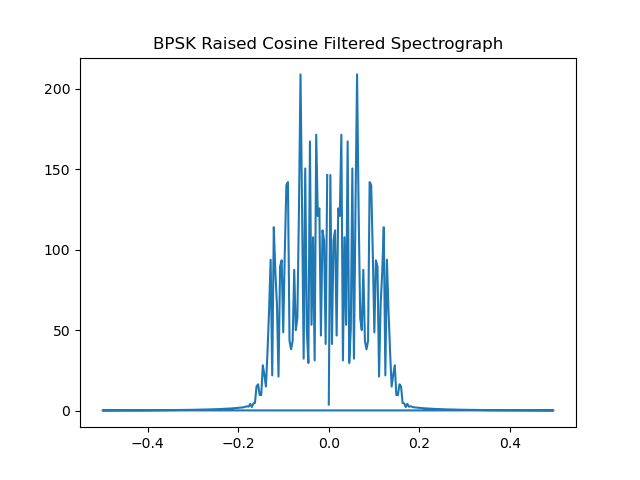

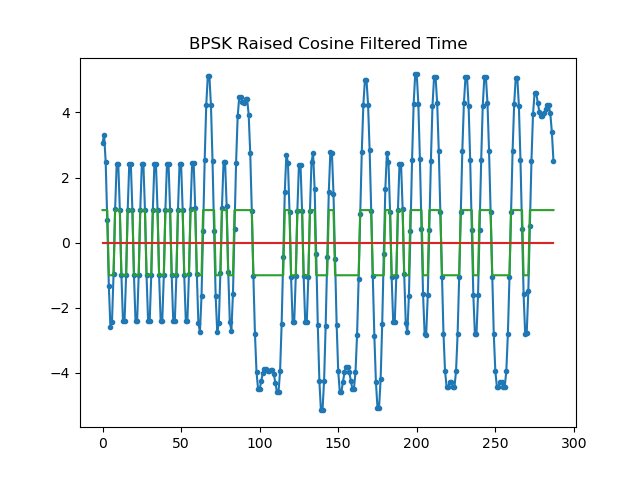

In [55]:
#Now try it on the modulated signal and see what happens
raised_cos_filtered = signal.convolve(symbols, root_raised, mode='same')


%matplotlib widget
plt.figure("BPSK Raised Cosine Filtered Time")
plt.title("BPSK Raised Cosine Filtered Time")
plt.plot(raised_cos_filtered.real, '.-')
plt.plot(raised_cos_filtered.imag)
plt.plot(symbols.real)
plt.plot(symbols.imag)

plt.show

yf = fft.fft(raised_cos_filtered)
freqs = fft.fftfreq(raised_cos_filtered.size)

plt.figure("BPSK Raised Cosine Filtered Spectrograph")
plt.title("BPSK Raised Cosine Filtered Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

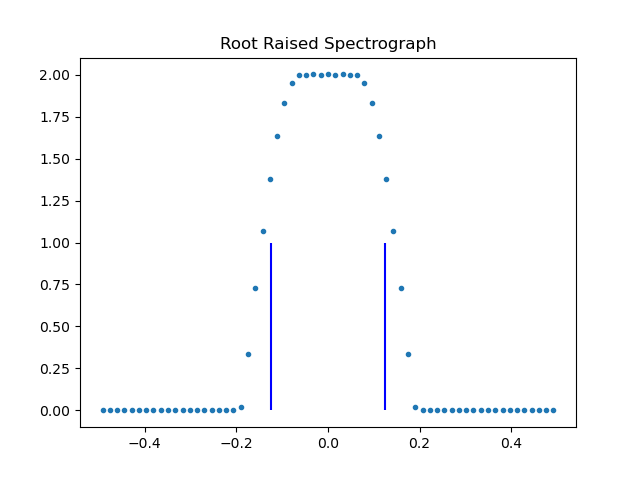

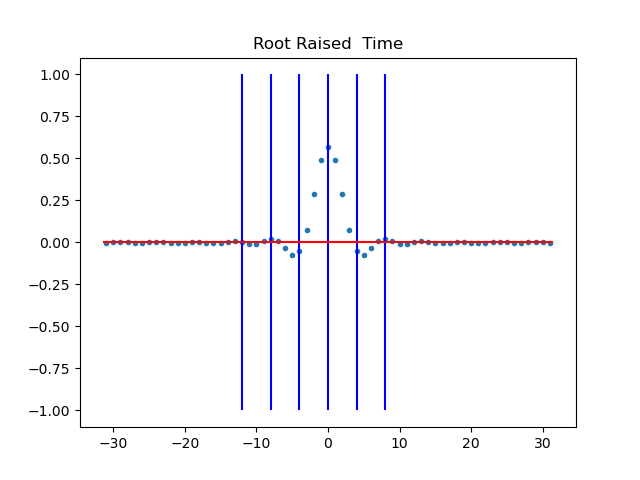

In [56]:
# Now make the raised cosine filter. This is done to create a matched filter for the tx and rx sides. 
def rootRaisedCos(ntaps, sps, excess_bw):
    n = np.arange(ntaps) - (ntaps-1)//2

    #avoid divide by 0 issue in rrc equation
    while sps/(4*excess_bw) in n:
        excess_bw += .001

    a = excess_bw
    
    #Gracefully ignore divide by 0 when n=0
    with np.errstate(divide='ignore', invalid='ignore'):
        rrc = np.cos(np.pi*(1+a)*n/sps) + sps/(4*a*n) * np.sin(np.pi*(1-a)*n/sps)
        rrc *= 4*a/(np.pi*np.sqrt(sps)) / (1 - (4*a*n/sps)**2)
        
    #Handle divide by zero condition when n=0
    rrc[np.argwhere(np.isnan(rrc))] = (1+a*(4/np.pi-1))/np.sqrt(sps)
    
    return n, rrc

n, rrc = rootRaisedCos(ntaps, sps, .51)

%matplotlib widget
plt.figure("Root Raised over Time")
plt.title("Root Raised  Time")
plt.plot(n, rrc, '.')
plt.vlines(np.arange(-3*sps, 3*sps, sps), -1, 1, 'b')
plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show

yf = fft.fft(rrc)
freqs = fft.fftfreq(rrc.size)

plt.figure("Root Raised Spectrograph")
plt.title("Root Raised Spectrograph")
plt.plot(freqs, np.abs(yf), '.')
plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()

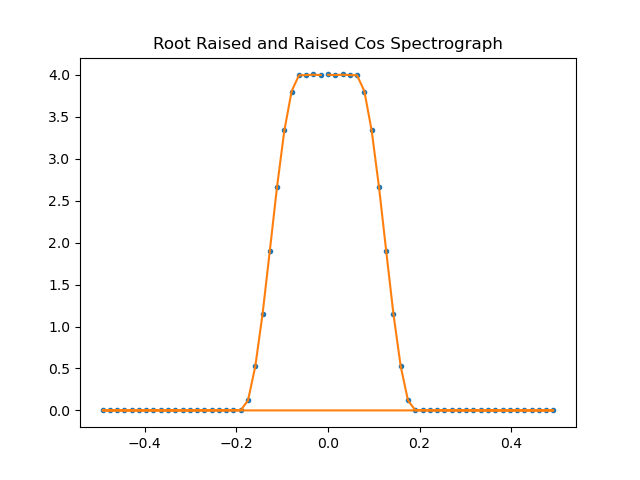

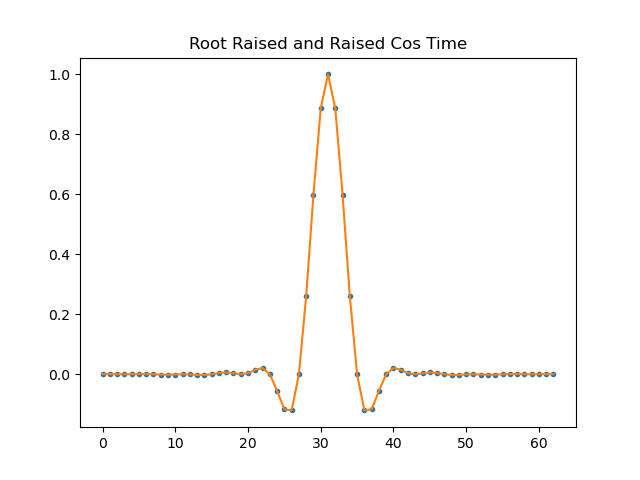

In [57]:
#Verify that 2 RRC is equal to a raised cos filter. This is to check that the algorithm is correct
rrc2 = signal.convolve(rrc, rrc, mode='same')

%matplotlib widget
plt.figure("Root Raised and Raised Cos over Time")
plt.title("Root Raised and Raised Cos Time")
plt.plot(rrc2, '.')
plt.plot(root_raised, '-')
#plt.vlines(np.arange(-3*sps, 3*sps, sps), -1, 1, 'b')
#plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show

yf_rrc2 = fft.fft(rrc2)
freqs_rrc2 = fft.fftfreq(rrc2.size)

yf_rc = fft.fft(root_raised)
freqs_rc = fft.fftfreq(root_raised.size)

plt.figure("Root Raised and Raised Cos Spectrograph")
plt.title("Root Raised and Raised Cos Spectrograph")
plt.plot(freqs_rrc2, np.abs(yf_rrc2), '.')
plt.plot(freqs_rc, np.abs(yf_rc), '-')
#plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()



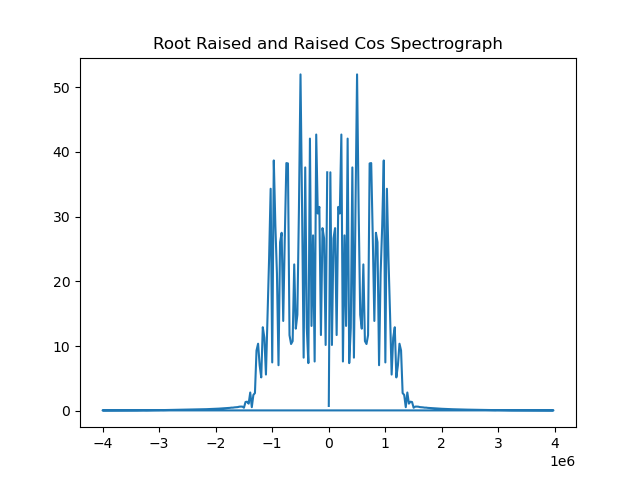

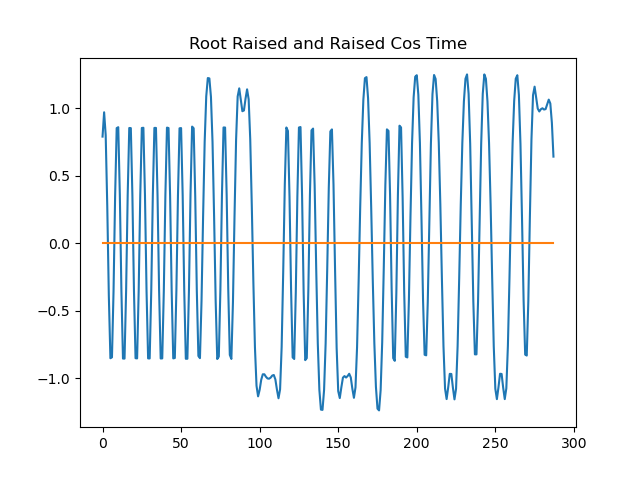

In [65]:
# apply RRC to modulated signal. This is the transmitted signal.
symbols2 = np.concatenate([np.zeros(500), symbols, np.zeros(500)])
symbols2 = symbols
tx_waveform = signal.convolve(symbols2, rrc, mode='same')*.5

%matplotlib widget
plt.figure("Root Raised and Raised Cos over Time")
plt.title("Root Raised and Raised Cos Time")
plt.plot(tx_waveform.real)
plt.plot(tx_waveform.imag)
plt.show

yf = fft.fft(tx_waveform)
freqs = fft.fftfreq(tx_waveform.size, d=1/fs)

plt.figure("Root Raised and Raised Cos Spectrograph")
plt.title("Root Raised and Raised Cos Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

In [66]:
# Write to file
#Pad zeros to view in inspectrum easier
tx_waveform = np.concatenate([np.zeros(500), symbols2, np.zeros(500)])
tx_waveform.tofile("tx_sim.iq")